In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from utils import evaluate_binary_clf, feature_transformer, DEFAULT_VALS

%load_ext autoreload
%autoreload 2

In [2]:
X_train = pd.read_parquet("./modelling_data/X_train.parquet")
y_train = pd.read_parquet("./modelling_data/y_train.parquet")
X_test = pd.read_parquet("./modelling_data/X_test.parquet")
y_test = pd.read_parquet("./modelling_data/y_test.parquet")

X_train["Month"] = X_train["Date"].dt.month
X_test["Month"] = X_test["Date"].dt.month
X_train.drop(columns=["Date"], inplace=True)
X_test.drop(columns=["Date"], inplace=True)

In [3]:
X_train.update(X_train.groupby("Location").ffill())
X_test.update(X_test.groupby("Location").ffill())

for col in X_train:
    X_train[col] = X_train[col].fillna(DEFAULT_VALS.get(col, np.nan))

for col in X_test:
    X_test[col] = X_test[col].fillna(DEFAULT_VALS.get(col, np.nan))

cols_to_lag = ["Temp9am", "Temp3pm", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm"]

shifted = X_train.groupby("Location")[cols_to_lag].shift(1)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG1")
X_train = X_train.merge(shifted, left_index=True, right_index=True)

shifted = X_test.groupby("Location")[cols_to_lag].shift(1)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG1")
X_test = X_test.merge(shifted, left_index=True, right_index=True)

shifted = X_train.groupby("Location")[cols_to_lag].shift(2)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG2")
X_train = X_train.merge(shifted, left_index=True, right_index=True)

shifted = X_test.groupby("Location")[cols_to_lag].shift(2)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG2")
X_test = X_test.merge(shifted, left_index=True, right_index=True)
    
X_train = feature_transformer(X_train)
X_test = feature_transformer(X_test)
X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154177 entries, 0 to 154176
Data columns (total 46 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Location          154177 non-null  string 
 1   MinTemp           154177 non-null  float64
 2   MaxTemp           154177 non-null  float64
 3   Rainfall          154177 non-null  float64
 4   Evaporation       154177 non-null  float64
 5   Sunshine          154177 non-null  float64
 6   WindGustDir       154177 non-null  float64
 7   WindGustSpeed     154177 non-null  float64
 8   WindDir9am        154177 non-null  float64
 9   WindDir3pm        154177 non-null  float64
 10  WindSpeed9am      154177 non-null  float64
 11  WindSpeed3pm      154177 non-null  float64
 12  Humidity9am       154177 non-null  float64
 13  Humidity3pm       154177 non-null  float64
 14  Pressure9am       154177 non-null  float64
 15  Pressure3pm       154177 non-null  float64
 16  Cloud9am          15

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustDir  \
0  Canberra      8.0     24.3       0.0          3.4       6.3     0.707107   
1  Canberra     14.0     26.9       3.6          4.4       9.7     0.382683   
2  Canberra     13.7     23.4       3.6          5.8       3.3     0.707107   
3  Canberra     13.3     15.5      39.8          7.2       9.1     0.707107   
4  Canberra      7.6     16.1       2.8          5.6      10.6    -0.923880   

   WindGustSpeed    WindDir9am    WindDir3pm  ...     FEAT3  FEAT4  FEAT5  \
0           30.0 -7.071068e-01  7.071068e-01  ...  0.957055  -39.0   -4.7   
1           39.0  6.123234e-17 -1.836970e-16  ...  0.906977  -44.0   -4.0   
2           85.0  1.000000e+00  9.238795e-01  ...  0.670103  -13.0   -2.3   
3           54.0  3.826834e-01 -1.836970e-16  ...  0.363636   -6.0    1.5   
4           50.0 -9.238795e-01 -3.826834e-01  ...  0.917647  -19.0    0.2   

       FEAT6  FEAT7      FEAT8         FEAT9        FEAT10        FEAT11  \
0   5.307112  21.42  21.213203 -4.242641e-01  1.414214e+00  1.838478e+00   
1  21.328094  42.68  14.924654  2.449294e-17 -3.122849e-16 -3.367779e-16   
2   4.306068  19.14  60.104076  6.000000e-01  5.543277e-01 -4.567228e-02   
3  36.543298  65.52  38.183766  1.148050e+00 -4.408728e-16 -1.148050e+00   
4  24.880789  59.36 -46.193977 -1.847759e+00 -1.071514e+00  7.762455e-01   

     FEAT12  
0   9.94350  
1   6.63024  
2  13.94968  
3  12.63920  
4  11.99065  

[5 rows x 46 columns]

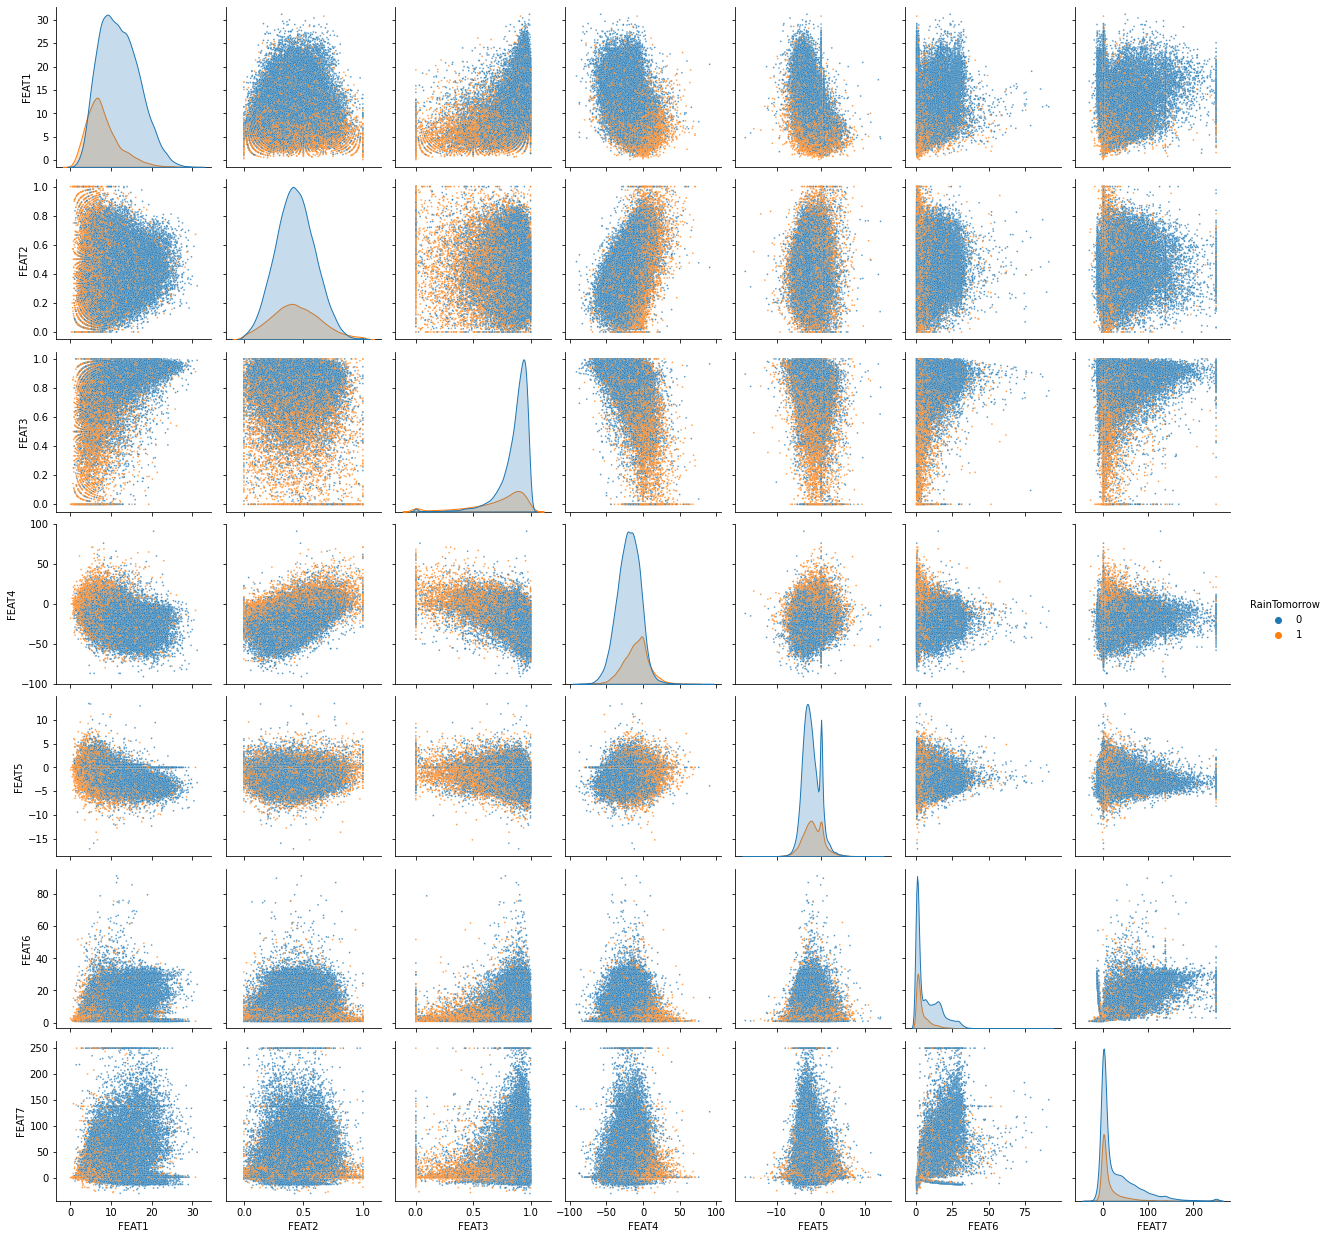

In [4]:
sns.pairplot(X_train.merge(y_train, left_index=True, right_index=True)[[col for col in X_train if "FEAT" in col][:7] + ["RainTomorrow"]].sample(50000),
             hue="RainTomorrow",
             plot_kws={"alpha": 0.75, "s": 3})

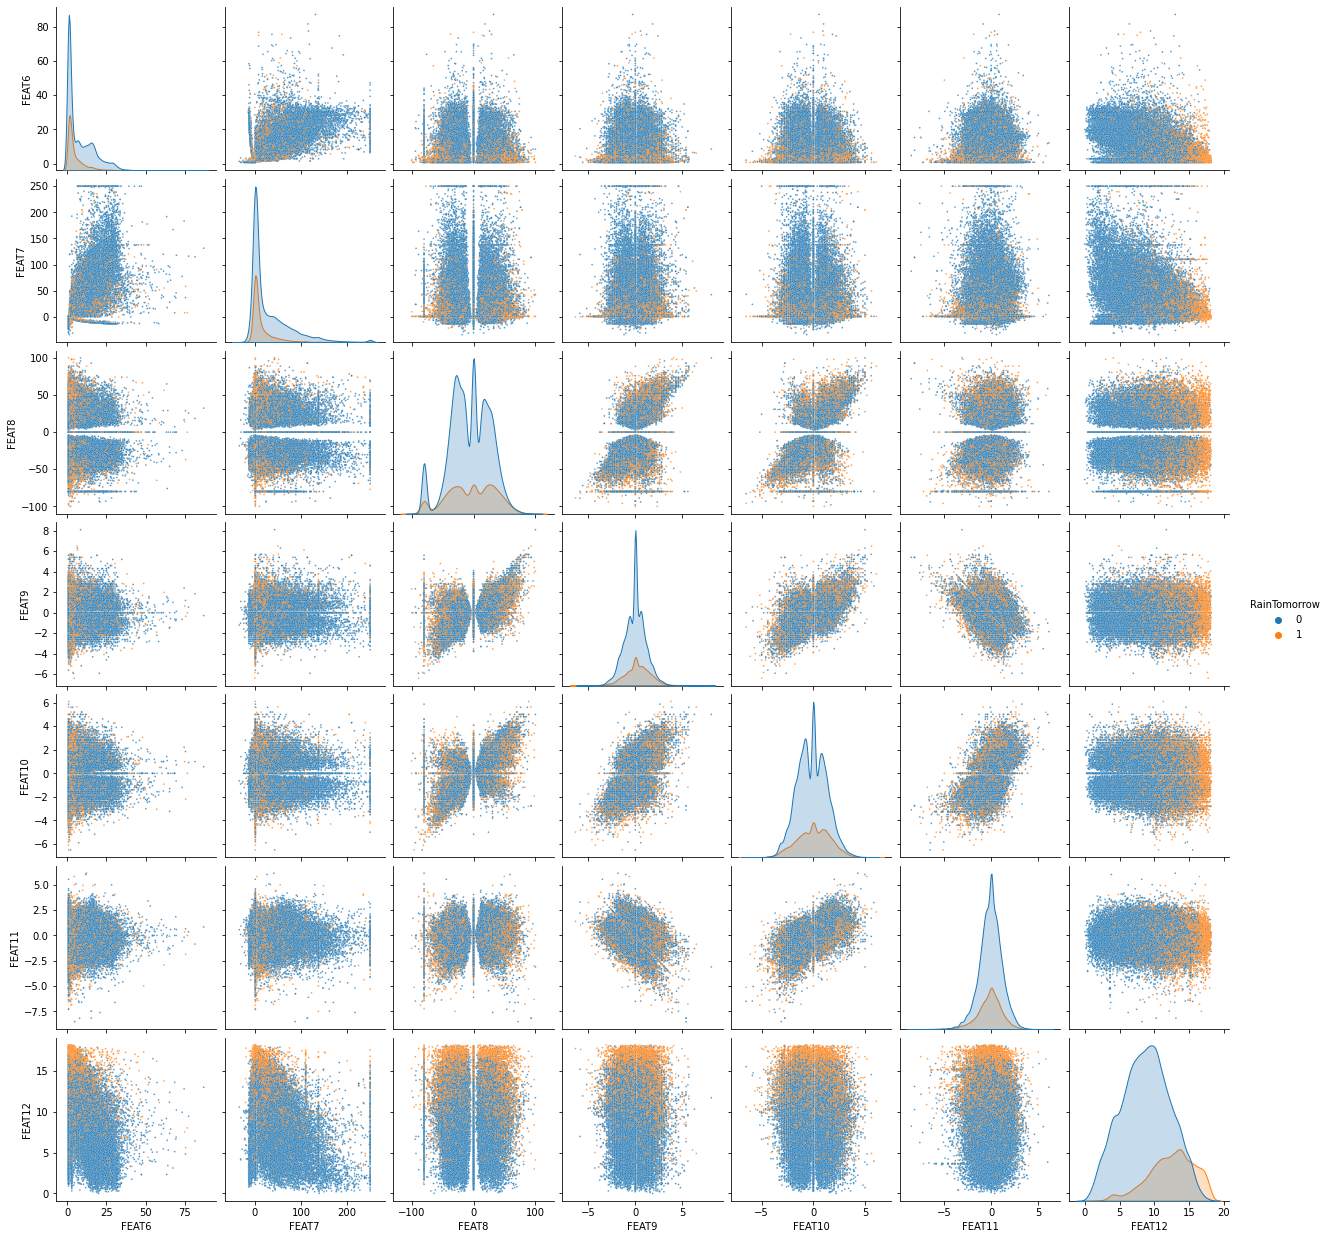

In [5]:
sns.pairplot(X_train.merge(y_train, left_index=True, right_index=True)[[col for col in X_train if "FEAT" in col][5:] + ["RainTomorrow"]].sample(50000),
             hue="RainTomorrow",
             plot_kws={"alpha": 0.75, "s": 3})

In [6]:
param_distribs = {
    "n_estimators": [200, 250, 300, 350, 400, 450],
    "max_depth": [6, 8, 10, 12, 14, 16, 18, 20],
    "num_leaves": [25, 30, 35, 40, 45, 50, 55, 60],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "reg_lambda": [0, 0.5, 1, 5, 10, 50]
}

clf = lgb.LGBMClassifier(n_jobs=-1, random_state=0, silent=False)
ts_cv = TimeSeriesSplit(n_splits=4)
searcher = RandomizedSearchCV(
    clf,
    param_distributions=param_distribs,
    n_iter=75,
    scoring="balanced_accuracy",
    n_jobs=-1,
    cv=ts_cv,
    random_state=0
)
searcher.fit(X_train.drop(columns=["Location"]), y_train["RainTomorrow"])

[LightGBM] [Info] Number of positive: 34365, number of negative: 119812
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8025
[LightGBM] [Info] Number of data points in the train set: 154177, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222893 -> initscore=-1.248885
[LightGBM] [Info] Start training from score -1.248885


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=LGBMClassifier(random_state=0, silent=False),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'max_depth': [6, 8, 10, 12, 14, 16, 18,
                                                      20],
                                        'n_estimators': [200, 250, 300, 350,
                                                         400, 450],
                                        'num_leaves': [25, 30, 35, 40, 45, 50,
                                                       55, 60],
                                        'reg_lambda': [0, 0.5, 1, 5, 10, 50],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1]},
                   random_state=0, scoring='balanced_accuracy')

In [7]:
pd.DataFrame(searcher.cv_results_).drop(columns=['params']).sort_values(by="rank_test_score").head(25)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       15.856688      3.706112         2.995168        0.212760   
25      16.771473      5.815852         3.040904        0.169732   
14      17.568995      4.189070         3.359909        0.239824   
50      11.638762      3.159677         2.062562        0.117087   
61      10.628802      4.151715         1.750558        0.096996   
0       12.822374      4.259599         2.270570        0.092288   
55      14.441705      4.467726         2.403600        0.156750   
3       12.356692      4.044056         2.310043        0.105423   
74      11.782195      1.964817         2.032196        0.231267   
16      12.019941      3.262033         2.037078        0.094237   
67      10.883520      4.044135         1.876215        0.187671   
47      14.732945      3.664489         2.578116        0.176254   
20      10.921996      3.412904         1.925794        0.106711   
68      13.930842      5.251101         2.212375        0.121549   
1       12.102172      4.277542         1.677183        0.086101   
53       8.645622      2.693947         1.452526        0.064179   
59       7.441567      2.610546         1.281489        0.037411   
49      14.145104      5.002177         2.246581        0.147826   
70       7.553910      2.590219         1.310531        0.017415   
18      12.378430      3.852807         2.052704        0.132055   
32      12.801658      3.792917         2.037557        0.128013   
23      12.196490      3.509285         2.057589        0.087920   
21      12.023381      3.498727         2.037764        0.117924   
46       9.362167      2.834276         1.727098        0.022309   
44      12.172601      4.065420         2.068302        0.084512   

   param_subsample param_reg_lambda param_num_leaves param_n_estimators  \
5                1               50               55                400   
25             0.7               50               45                450   
14             0.6               50               55                450   
50             0.9               50               45                300   
61             0.8               50               45                250   
0              0.7               50               40                350   
55             0.7               50               30                450   
3              0.5               10               35                450   
74             0.5                5               60                450   
16             0.9               10               60                300   
67             0.8               50               25                350   
47             0.8               10               60                400   
20             0.8               50               40                300   
68             0.6               10               35                450   
1                1               50               40                250   
53             0.5               50               30                250   
59             0.7               50               35                200   
49               1                5               50                400   
70             0.8               50               35                200   
18               1               10               35                400   
32               1              0.5               55                400   
23             0.5               10               60                300   
21             0.5               10               45                350   
46             0.5               10               60                250   
44             0.8               10               30                450   

   param_max_depth  split0_test_score  split1_test_score  split2_test_score  \
5               10           0.747586           0.753734           0.729299   
25              10           0.748714           0.753452           0.725202   
14              16           0.746637          

In [8]:
graph = lgb.create_tree_digraph(searcher.best_estimator_)
graph.render(filename="feature_eng")

'feature_eng.pdf'

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     40925
           1       0.73      0.53      0.62     10468

    accuracy                           0.86     51393
   macro avg       0.81      0.74      0.77     51393
weighted avg       0.86      0.86      0.86     51393



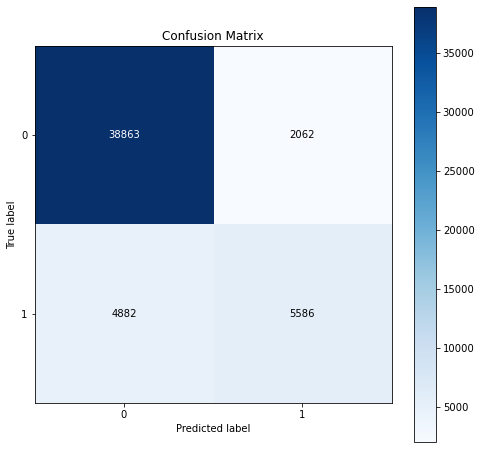

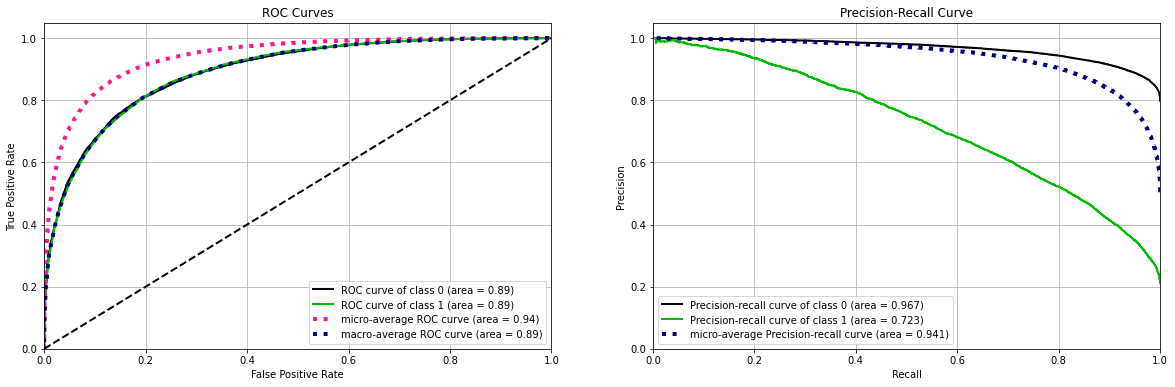

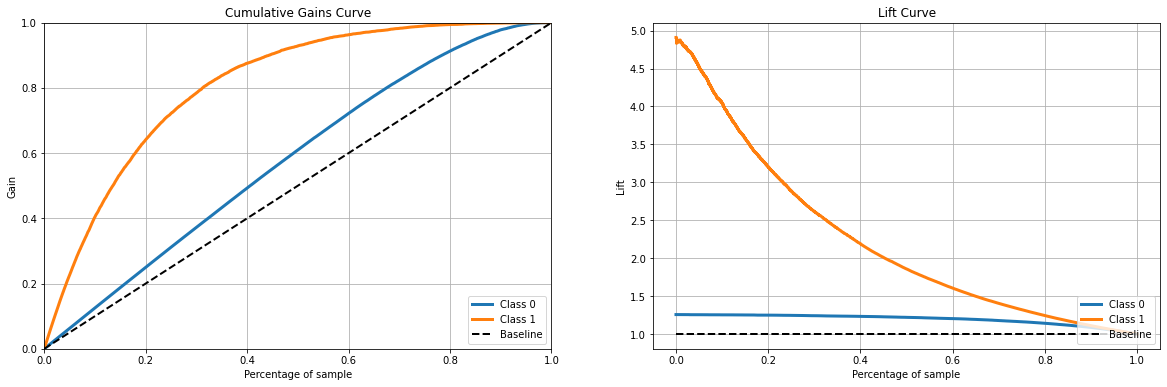

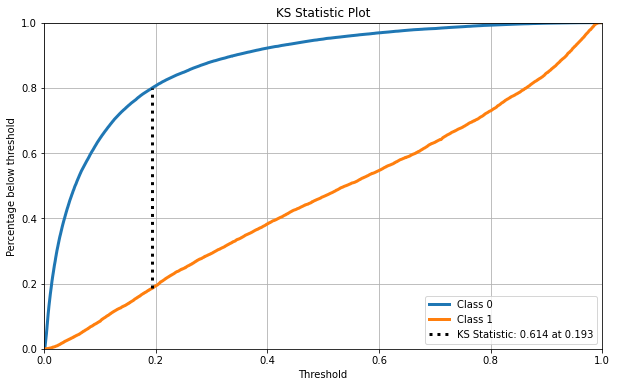

In [9]:
evaluate_binary_clf(
    X_test.drop(columns=["Location"]),
    y_test["RainTomorrow"],
    searcher.best_estimator_
)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

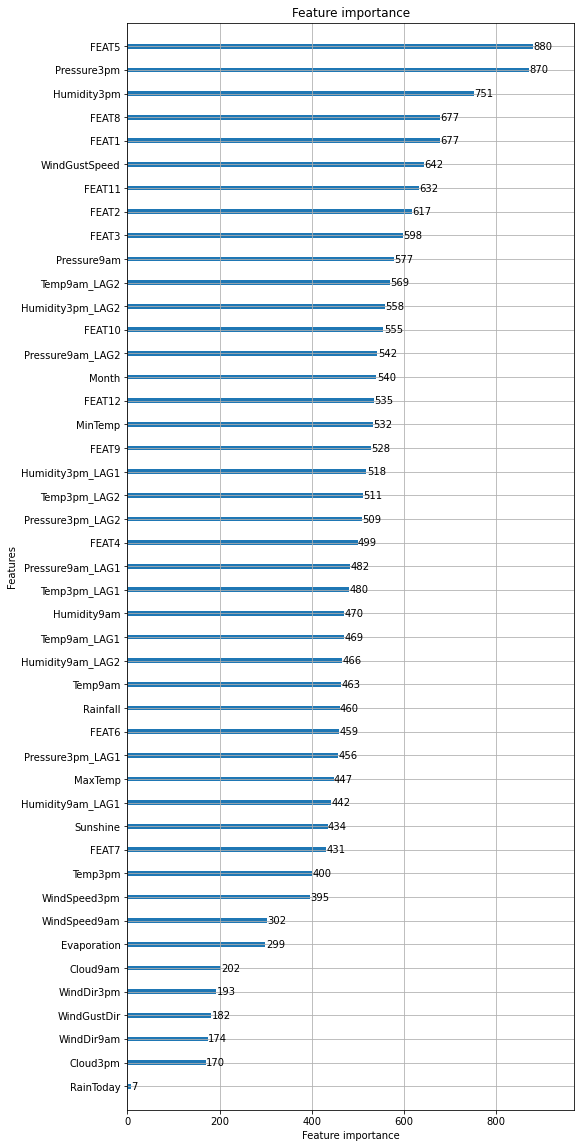

In [10]:
lgb.plot_importance(searcher.best_estimator_, figsize=(8, 20))

# Evaluation on train set to check for overfitting

              precision    recall  f1-score   support

           0       0.90      0.97      0.93    119812
           1       0.84      0.65      0.73     34365

    accuracy                           0.89    154177
   macro avg       0.87      0.81      0.83    154177
weighted avg       0.89      0.89      0.89    154177



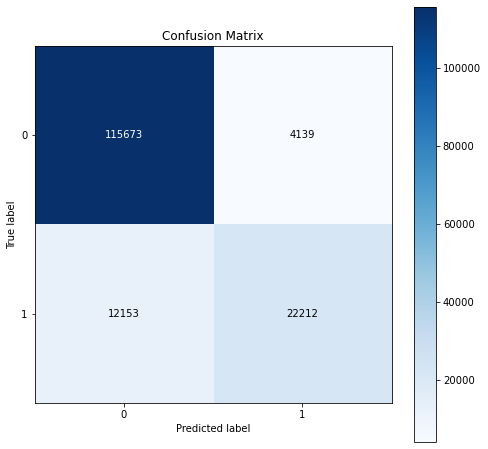

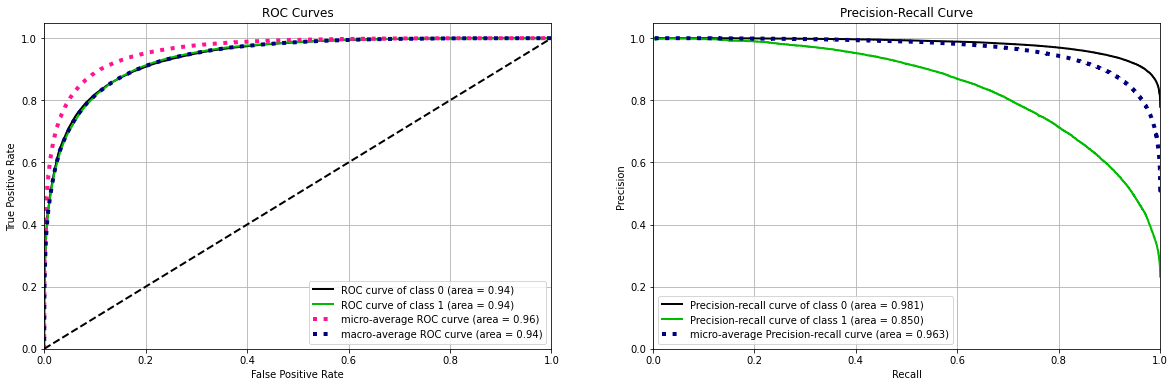

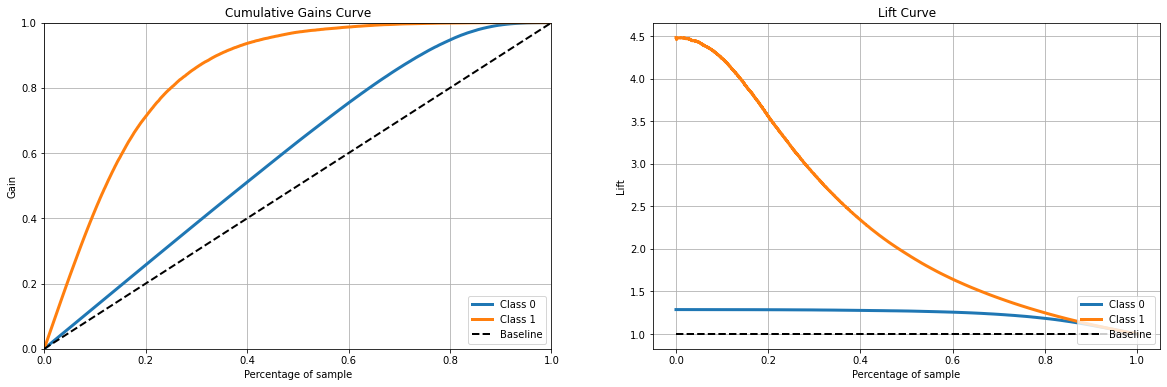

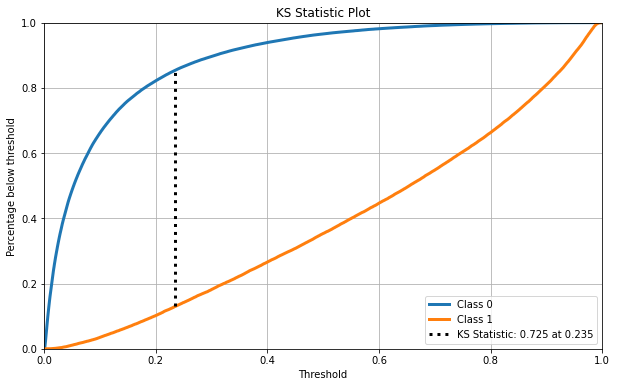

In [11]:
evaluate_binary_clf(
    X_train.drop(columns=["Location"]),
    y_train["RainTomorrow"],
    searcher.best_estimator_
)

In [12]:
confidence = searcher.best_estimator_.predict_proba(X_test.drop(columns=["Location"])).max(1)
pred = searcher.best_estimator_.predict(X_test.drop(columns=["Location"]))
X_test["confidence"] = confidence
X_test["pred"] = pred
X_test["actual"] = y_test["RainTomorrow"]
X_test["correct"] = (X_test["pred"] == X_test["actual"])

In [13]:
X_test["correct"] = (X_test["pred"] == X_test["actual"])

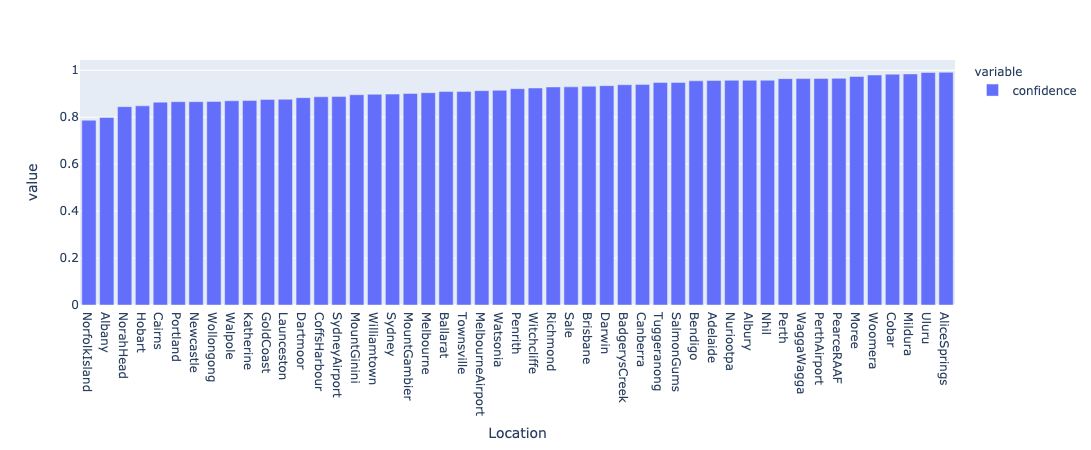

In [14]:
X_test.groupby("Location")['confidence'].median().sort_values().plot.bar(backend='plotly')

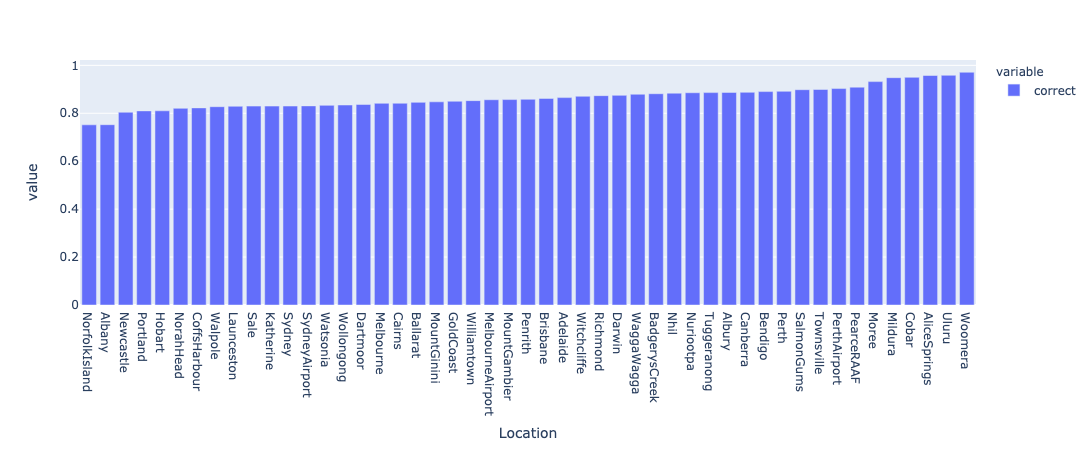

In [15]:
X_test.groupby("Location")["correct"].apply(lambda s: s.sum()/len(s)).sort_values().plot.bar(backend='plotly')

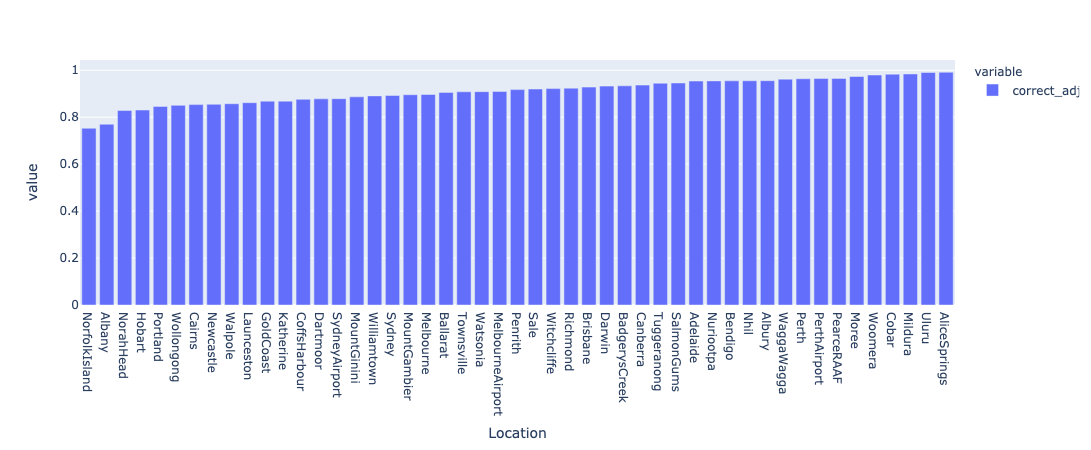

In [16]:
(X_test
 .assign(correct_adj=X_test["correct"]*X_test["confidence"])
 .groupby("Location")["correct_adj"]
 .median()
 .sort_values().plot.bar(backend='plotly'))

In [17]:
raw_X_test = pd.read_parquet("./modelling_data/X_test.parquet")
raw_X_test["confidence"] = confidence
raw_X_test["pred"] = pred
raw_X_test["actual"] = y_test["RainTomorrow"]
raw_X_test["correct"] = (raw_X_test["pred"] == raw_X_test["actual"])

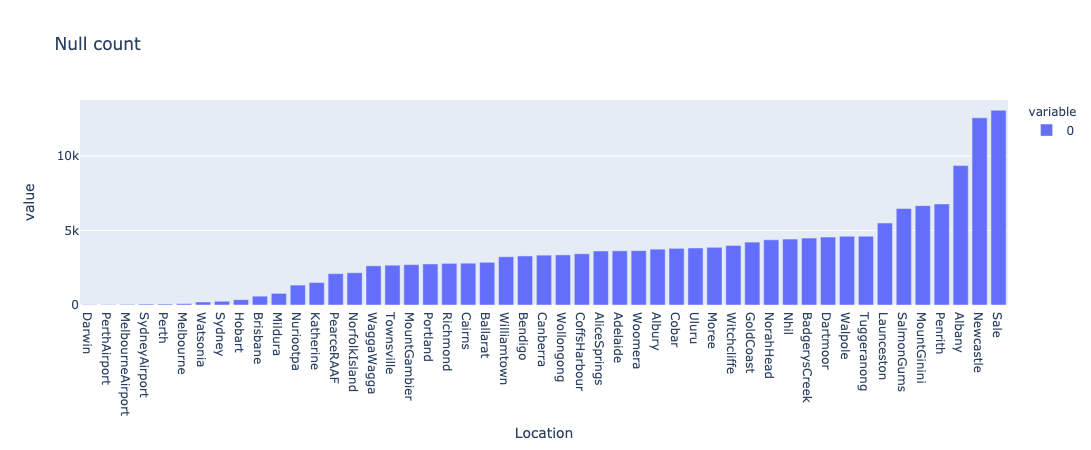

In [18]:
raw_X_test.groupby("Location").apply(lambda df: df.isna().sum().sum()).sort_values().plot.bar(backend='plotly', title='Null count')

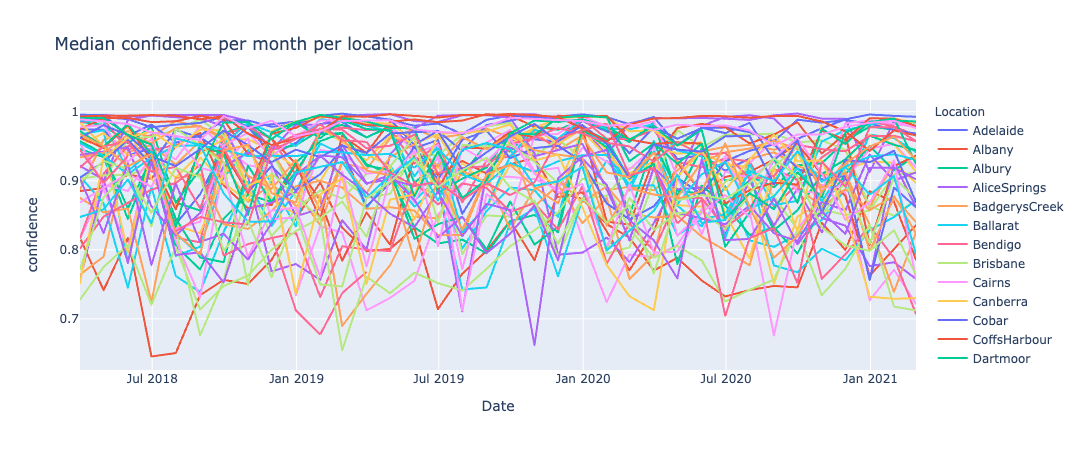

In [19]:
fig = px.line(
    (raw_X_test
     .set_index("Date")
     .groupby("Location")
     .resample("M")["confidence"]
     .median()
     .reset_index()),
    x='Date',
    y='confidence',
    color='Location',
    title="Median confidence per month per location"
)
fig.show()

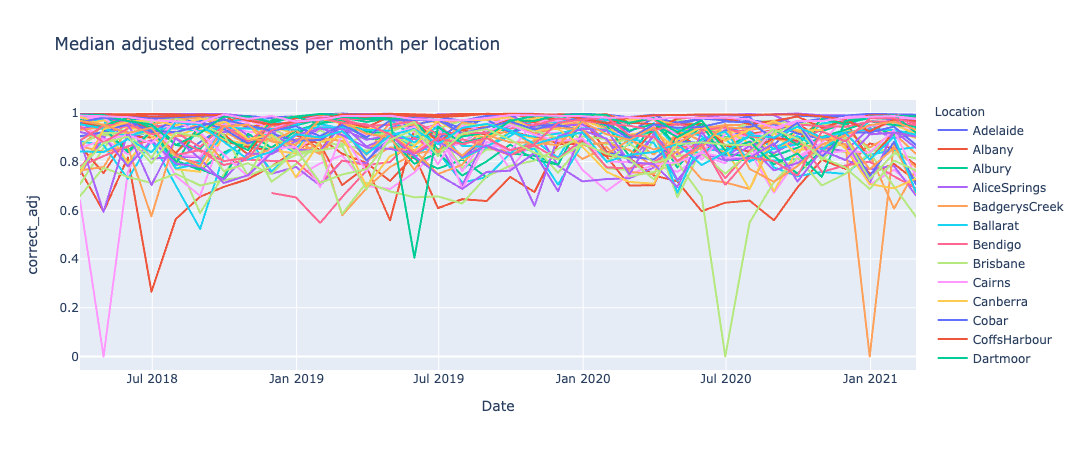

In [20]:
fig = px.line(
    (raw_X_test
     .assign(correct_adj=X_test["correct"]*X_test["confidence"])
     .set_index("Date")
     .groupby("Location")
     .resample("M")["correct_adj"]
     .median()
     .reset_index()),
    x='Date',
    y='correct_adj',
    color='Location',
    title="Median adjusted correctness per month per location"
)
fig.show()

/Users/ajaypethani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in long_scalars



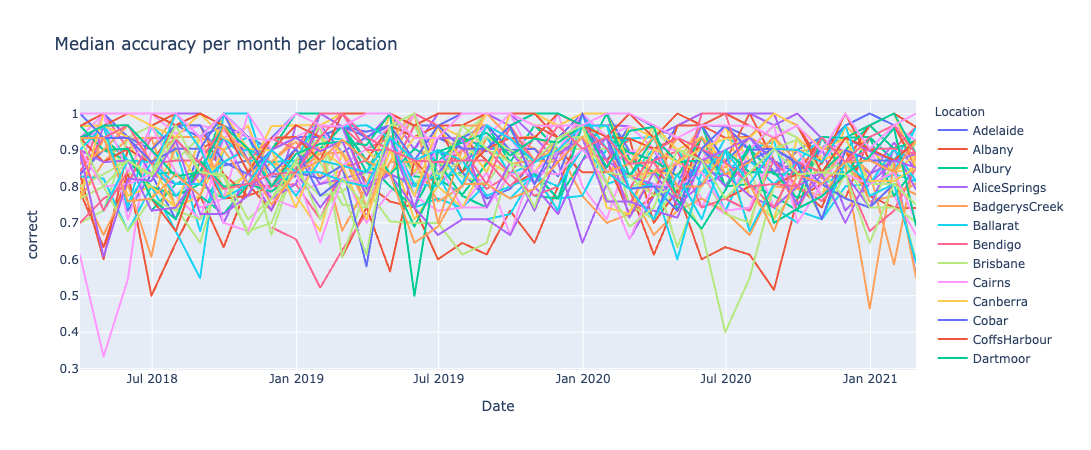

In [21]:
fig = px.line(
    (raw_X_test
     .set_index("Date")
     .groupby("Location")
     .resample("M")["correct"]
     .apply(lambda s: s.sum()/len(s))
     .reset_index()),
    x='Date',
    y='correct',
    color='Location',
    title="Median accuracy per month per location"
)
fig.show()